In [1]:
import pandas as pd
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import ipywidgets as widgets
import seaborn as sns
import IPython.display as ipd
import plotly.express as px

In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:60% !important; }</style>"))

C:\Users\mdfai\AppData\Local\Temp\ipykernel_13512\3710136257.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### The Next cell basically manages the dataset to have similar country names. Many Countries are not in the json file that we have. So we are getting rid of it. 

In [24]:
# Load the CSV file

pop_raw = pd.read_csv('./population-and-demography.csv')
male_pop_raw = pd.read_csv('./Male - population-and-demography.csv')
female_pop_raw = pd.read_csv('./female - population-and-demography.csv')
life_expec_raw = pd.read_csv('./life expectancy - population-and-demography.csv')
death_rate_raw = pd.read_csv('./death rate - population-and-demography.csv')
birth_rate_raw = pd.read_csv('./birth rate - population-and-demography.csv')
child_death_raw = pd.read_csv('./child mortality rate - population-and-demography.csv')
other_data_raw = pd.read_csv('./Other data - Copy.csv')


                   
# List of non-country entries created by chat GPT 
non_countries = [
    'Africa (UN)', 'Asia (UN)', 'Europe (UN)', 'High-income countries', 'Land-locked developing countries (LLDC)', 
    'Latin America and the Caribbean (UN)', 'Least developed countries', 'Less developed regions', 
    'Less developed regions, excluding China', 'Less developed regions, excluding least developed countries', 
    'Low-income countries', 'Lower-middle-income countries', 'More developed regions', 'Northern America (UN)',
    'Oceania (UN)', 'Small island developing states (SIDS)', 'Upper-middle-income countries', 'World', 'Aruba', 'Barbados', 'Burundi', 'Saint Barthelemy', 'Bermuda', 'Brunei',
    'Bonaire Sint Eustatius and Saba', "Cote d'Ivoire", 'Curacao', 'Falkland Islands',
    'French Guiana', 'Guernsey', 'Guam', 'Jersey', 'Kiribati', 'Saint Martin (French part)',
    'Northern Mariana Islands', 'Nauru', 'Niue', 'Reunion', 'Rwanda',
    'Sint Maarten (Dutch part)', 'Tokelau', 'Turkey', 'Kosovo', 'Yemen' 
]

# Filter out the non-country entries
pop = pop_raw[~pop_raw['Country name'].isin(non_countries)]
male_pop = male_pop_raw[~male_pop_raw['Country name'].isin(non_countries)]
female_pop = female_pop_raw[~female_pop_raw['Country name'].isin(non_countries)]
life_expec_raw2 = life_expec_raw[~life_expec_raw['Country name'].isin(non_countries)]
death_rate_raw2 = death_rate_raw[~death_rate_raw['Country name'].isin(non_countries)]
birth_rate_raw2 = birth_rate_raw [~birth_rate_raw ['Country name'].isin(non_countries)]
child_death_raw2 = child_death_raw[~child_death_raw['Country name'].isin(non_countries)]
other_data_raw2 = other_data_raw[~other_data_raw['Country name'].isin(non_countries)]

#Filter out 'Vatican' from some files
death_rate = death_rate_raw2[death_rate_raw2['Country name'] != 'Vatican']
birth_rate = birth_rate_raw2[birth_rate_raw2['Country name'] != 'Vatican']
child_death = child_death_raw2[child_death_raw2['Country name'] != 'Vatican']
life_expec = life_expec_raw2[life_expec_raw2['Country name'] != 'Vatican']
other_data = other_data_raw2[other_data_raw2['Country name'] != 'Vatican']


### In the next cell I only kept the column that I will use 

In [16]:
pop = pop[['Country name', 'Year', 'Population']]
male_pop = male_pop[['Country name', 'Year', 'Male population']]
female_pop = female_pop[['Country name', 'Year', 'Female population']]


### All the data we had didn't have any ISO3 code with them which we will use to make a link with our worl.json file. So we used chatGPT to create the ISO3 for every countyr. The prompt was "Here is the name of the countires. Now use your knowledge to give me the ISO3 and ISO2 for the countires and give me the list in a CSV file"

In [17]:
iso = pd.read_csv('./Country_with_ISO_Codes.csv')

### Creating a new dataset combining all the data

In [6]:
dataframes = {
    'pop': pop,
    'male_pop': male_pop,
    'female_pop': female_pop,
    'death_rate': death_rate,
    'birth_rate': birth_rate,
    'child_death': child_death
}


columns_to_take = [
    ['Country name', 'Year', 'Population'],
    ['Country name', 'Year', 'Male population'],
    ['Country name', 'Year', 'Female population'],
    ['Country name', 'Year', 'Death rate'],
    ['Country name', 'Year', 'Birth rate'],
    ['Country name', 'Year', 'Child mortality rate']
]

# Initialize an empty DataFrame
final_df = pd.DataFrame()

# Iterate over the datasets and columns
for dataset_name, columns in zip(dataframes.keys(), columns_to_take):
    df = dataframes[dataset_name][columns]
    if final_df.empty:
        final_df = df
    else:
        final_df = final_df.merge(df, on=['Country name', 'Year'], how='inner')


#Merging data with ISO        
final = final_df.merge(iso, on='Country name', how='left')

# final.to_csv('./final.csv', index=False)

### Merging data for heatmap with GEO JSON

In [7]:
# Load the GeoJSON data
world_geo = gpd.read_file('./world.json')

# Filter the population data for the year 2021
final_2021 = final[final['Year'] == 2021]

# Merge the population data with geographical data using ISO3 codes
merged_data = world_geo.merge(final_2021, left_on='id', right_on='ISO3')

# Applying a logarithmic scale to the population data
merged_data['Log_Population'] = np.log1p(merged_data['Population'])

# Convert the merged GeoDataFrame to a GeoJSON format
geojson_data = json.loads(merged_data.to_json())


### Creating Heat map for different data

### Heat map of the world on Child Mortality Rate

In [8]:
# Create a Child mortality rate Choropleth map using Altair
choropleth_map_child = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Child mortality rate:Q', 
              scale=alt.Scale(scheme='viridis'),
              title='Child mortality rate',
              legend=alt.Legend(orient='bottom', legendX=8000)),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Child mortality rate:Q', title='Child Mortality Rate')
    ]
).properties(
    title='Child mortality rate',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)

# Customize chart title
choropleth_map_child = choropleth_map_child.properties(
    title=alt.TitleParams(
        text='Global Child Mortality Rate Distribution Map',   # Title text
        fontSize=26,        # Font size
        font='Futura',       # Font family
        color='black',      # Font color
        anchor='middle',     # Alignment (start, middle, end)
        dx=10,              # Shift title horizontally
        dy=-10              # Shift title vertically
    )
)

### Heat map of the world on Mortality Rate

In [9]:
# Create a Mortality rate Choropleth map using Altair
choropleth_map_death = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Death rate:Q', 
              scale=alt.Scale(scheme='viridis'),
              title='Mortality rate',
              legend=alt.Legend(orient='bottom', legendX=8000)),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Death rate:Q', title='Mortality Rate')
    ]
).properties(
    title='Mortality rate',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)

# Customize chart title
choropleth_map_death = choropleth_map_death.properties(
    title=alt.TitleParams(
        text='Global Mortality Rate Distribution Map',   # Title text
        fontSize=26,        # Font size
        font='Futura',       # Font family
        color='black',      # Font color
        anchor='middle',     # Alignment (start, middle, end)
        dx=10,              # Shift title horizontally
        dy=-10              # Shift title vertically
    )
)

### Heat map of the world on Population

In [10]:
# Create a Population Choropleth map using Altair
choropleth_map_pop = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Log_Population:Q', 
              scale=alt.Scale(scheme='viridis'),
              title='Logarithmic Population',
              legend = None),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Population:Q', title='Population')
    ]
).properties(
    title='Population',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)

# Customize chart title
choropleth_map_pop = choropleth_map_pop.properties(
    title=alt.TitleParams(
        text='Global Population Distribution Map',   # Title text
        fontSize=26,        # Font size
        font='Futura',       # Font family
        color='black',      # Font color
        anchor='middle',     # Alignment (start, middle, end)
        dx=10,              # Shift title horizontally
        dy=-10              # Shift title vertically
    )
)

### Heat map of the world on Birth Rate

In [11]:
# Create a birth rate Choropleth map using Altair



choropleth_map_birth = alt.Chart(alt.Data(values=geojson_data['features'])).mark_geoshape(
    stroke='white'
).encode(
    alt.Color('properties.Birth rate:Q', 
              scale=alt.Scale(scheme='viridis'),
              title='Birth rate',
              legend=alt.Legend(orient='bottom', legendX=8000)),
    tooltip=[
        alt.Tooltip('properties.Country name:N', title='Country'),
        alt.Tooltip('properties.Birth rate:Q', title='Birth rate')
    ]
).properties(
    title='Birth Rate',
    width=800,
    height=600
).project(
    type='naturalEarth1'
)




# Customize chart title
choropleth_map_birth = choropleth_map_birth.properties(
    title=alt.TitleParams(
        text='Global Birth Rate Distribution Map',   # Title text
        fontSize=26,        # Font size
        font='Futura',       # Font family
        color='black',      # Font color
        anchor='middle',     # Alignment (start, middle, end)
        dx=10,              # Shift title horizontally
        dy=-10              # Shift title vertically
    )
)



### This cell is interactive where you can choose map to show it from the drop down

In [12]:
charts = {
    "Population": choropleth_map_pop,
    "Birth Rate": choropleth_map_birth,
    "Mortality Rate": choropleth_map_death,
    "Child Mortality Rate": choropleth_map_child
    # Add other charts here if needed
}

# Function to display the selected chart
def show_chart(chart_name):
    with chart_output:
        chart_output.clear_output(wait=True)
        display(charts[chart_name])

dropdown_output = widgets.Output()
chart_output = widgets.Output()

# Create a dropdown to select the chart
dropdown = widgets.Dropdown(options=charts.keys(), description='Select Chart:')


def on_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        show_chart(change['new'])

dropdown.observe(on_dropdown_change, names='value')


with dropdown_output:
    display(dropdown)

with chart_output:
    display(charts[list(charts.keys())[0]])

# Display the output widgets
display(dropdown_output)
display(chart_output)

Output()

Output()

C:\Users\mdfai\AppData\Local\Temp\ipykernel_13512\1667312593.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



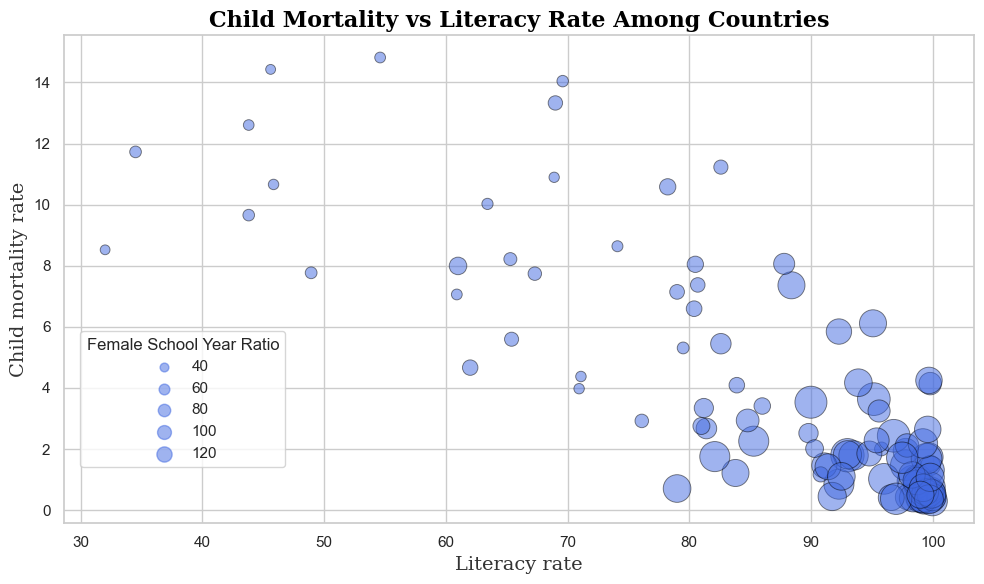

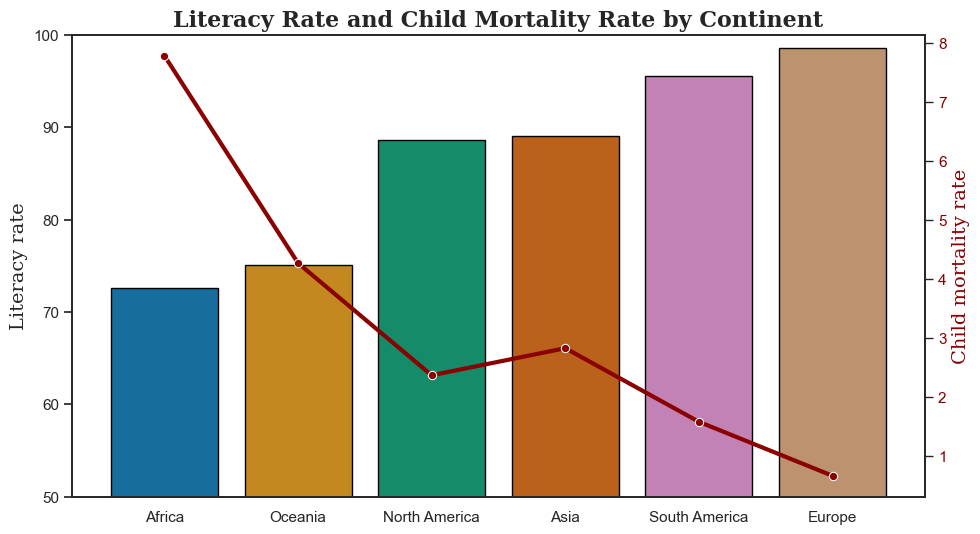

In [104]:
merged_df = pd.merge(other_data, child_death, on = 'Country name')
merged_df_1 = merged_df[merged_df['Year'] == 2011]
scaling_factor = 5  
merged_df_1['Scaled female school ratio'] = merged_df_1['female school year ratio'] ** scaling_factor


countries_to_remove2 = ['Australia', 'Equatorial Guinea']
merged_df_1 = merged_df_1[~merged_df_1['Country name'].isin(countries_to_remove2)]

# Create a scatter plot using columns from the DataFrame
sns.set_style("whitegrid")  # Set the style of the plot

fig, ax = plt.subplots(figsize=(10, 6))


# ax.set_facecolor('whitegrid')

# Create the scatter plot with customizations
scatter_plot = sns.scatterplot(data=merged_df_1, x='Literacy rate (2011)', y='Child mortality rate', size = 'Scaled female school ratio',edgecolor="black", color='royalblue', marker='o', sizes=(50, 1000), alpha = 0.5)



scatter_plot.set_title('Child Mortality vs Literacy Rate Among Countries', fontfamily='DejaVu Serif', fontsize=16, fontweight='bold', color='black')
scatter_plot.set_xlabel('Literacy rate', fontfamily='DejaVu Serif', fontsize=14, color='black', alpha = 0.8)
scatter_plot.set_ylabel('Child mortality rate', fontfamily='DejaVu Serif', fontsize=14, color='black', alpha = 0.8)

# Manually create a legend with original 'Female school ratio' values
legend_values = [40, 60, 80, 100, 120]  # Example values, choose according to your dataset
legend_labels = [f'{v}' for v in legend_values]
legend_handles = [plt.scatter([], [], s=v*1, color='royalblue', alpha=0.5) for v in legend_values]
legend = scatter_plot.legend(handles=legend_handles, labels=legend_labels, title='Female School Year Ratio', loc='lower left')
legend.set_bbox_to_anchor((0.01, 0.1, 0.2, 0.5))

# sns.regplot(data=merged_df_1, x='Literacy rate (2011)', y='Child mortality rate', scatter=False, color='red', label='Trend Line', line_kws={'linestyle': '-', 'linewidth': 2}, scatter_kws={'alpha': 1})

# Show the plot
plt.tight_layout() 
plt.show()
#NEW PLOT..................................................................................................................................................................
merged_df_1['Continent'] = merged_df_1['Continent'].str.strip()
comb_1 = merged_df_1.dropna(subset=['Continent', 'Literacy rate (2011)', 'Child mortality rate'])
average_values_by_continent = comb_1.groupby('Continent')[['Literacy rate (2011)', 'Child mortality rate']].mean()
average_values_by_continent = average_values_by_continent.sort_values(by='Literacy rate (2011)', ascending=True)

long_format_df = average_values_by_continent.reset_index().melt(id_vars='Continent', value_vars=['Literacy rate (2011)', 'Child mortality rate'])


# Removing the grid
sns.set_theme(style="white", rc={"axes.grid": False})

# Creating figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(11, 6))

# Bar chart for Literacy Rate with different colors
literacy_data = long_format_df[long_format_df['variable'] == 'Literacy rate (2011)']
sns.barplot(x='Continent', y='value', data=literacy_data, edgecolor="black", alpha=1, ax=ax1, palette="colorblind")
ax1.set_xlabel('', fontsize=12)
ax1.set_ylabel('Literacy rate',fontfamily='DejaVu Serif', fontsize=14)
ax1.tick_params(axis='y')
ax1.set_title('Literacy Rate and Child Mortality Rate by Continent',fontfamily='DejaVu Serif', fontsize=16, fontweight='bold')
ax1.set_ylim([50, 100])
# Line plot for GDP per Capita
ax2 = ax1.twinx()
gdp_data = long_format_df[long_format_df['variable'] == 'Child mortality rate']
sns.lineplot(x='Continent', y='value', data=gdp_data, marker='o', ax=ax2, color='darkred', linewidth=3)
ax2.set_ylabel('Child mortality rate',fontfamily='DejaVu Serif', fontsize=14, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred', width = 1)

# Customizing the background
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

# Show plot
plt.show()

C:\Users\mdfai\AppData\Local\Temp\ipykernel_13512\2585858473.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



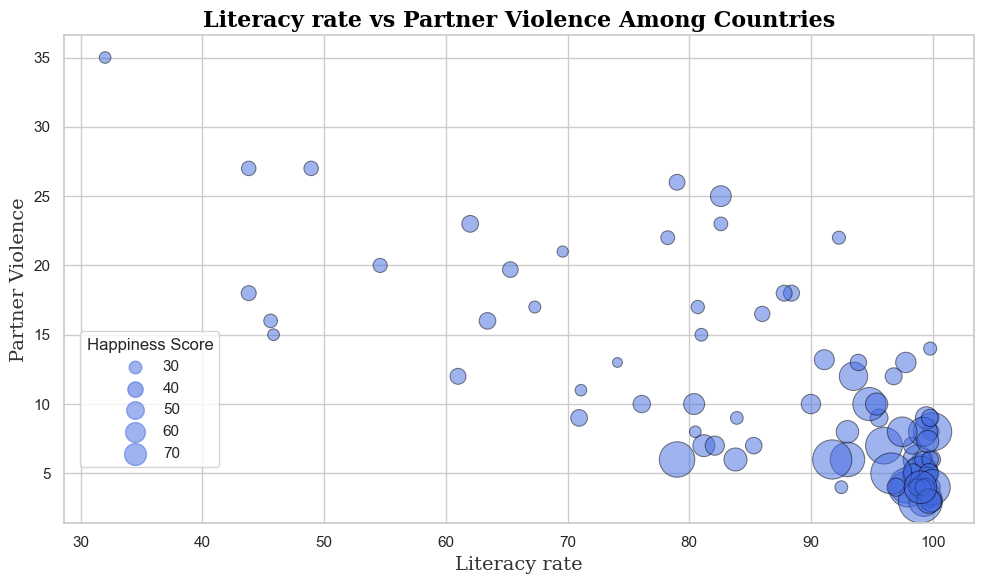

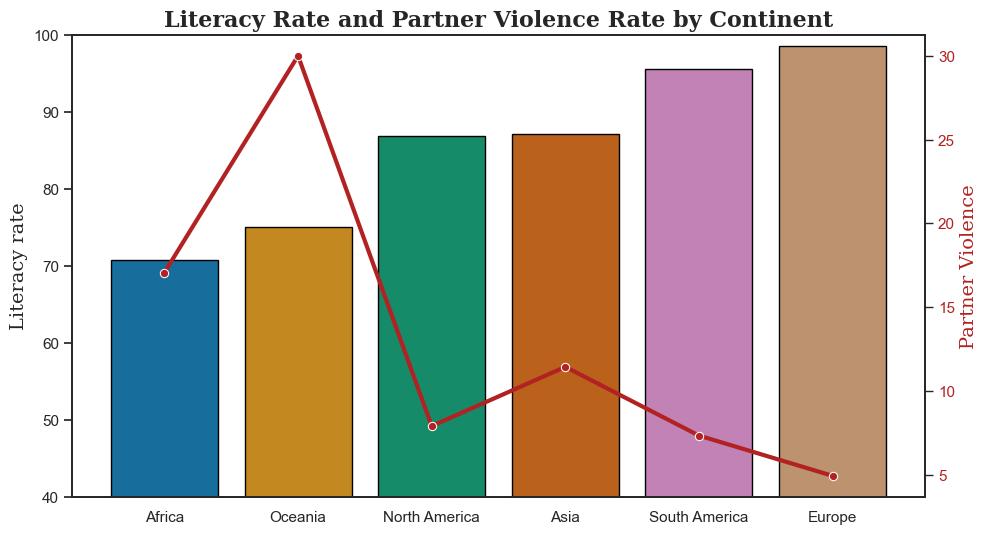

In [105]:
merged_df_2 = merged_df[merged_df['Year'] == 2011]

merged_df_2['Scaled Happiness Score'] = merged_df_2['Happiness Score (2011)'] ** scaling_factor

countries_to_remove3 = ['Australia', 'Equatorial Guinea', 'Papua New Guinea', 'Vanuatu']
merged_df_2 = merged_df_2[~merged_df_2['Country name'].isin(countries_to_remove2)]

# Create a scatter plot using columns from the DataFrame
sns.set_style("whitegrid")  # Set the style of the plot

fig, ax = plt.subplots(figsize=(10, 6))

# Create the scatter plot with customizations
scatter_plot = sns.scatterplot(data=merged_df_2, x='Literacy rate (2011)', y='Partner Violence (2018)',edgecolor="black", size ='Scaled Happiness Score', color='royalblue', marker='o', sizes=(50, 1000), alpha = 0.5)
scatter_plot.set_title('Literacy rate vs Partner Violence Among Countries',fontfamily='DejaVu Serif', fontsize=16, fontweight='bold', color='black')
scatter_plot.set_xlabel('Literacy rate',fontfamily='DejaVu Serif', fontsize=14, color='black', alpha = 0.8)
scatter_plot.set_ylabel('Partner Violence',fontfamily='DejaVu Serif', fontsize=14, color='black', alpha = 0.8)

# Manually create a legend with original 'Female school ratio' values
legend_values = [30, 40, 50, 60, 70]  # Example values, choose according to your dataset
legend_labels = [f'{v}' for v in legend_values]
legend_handles = [plt.scatter([], [], s=v**1.3, color='royalblue', alpha=0.5) for v in legend_values]
legend = scatter_plot.legend(handles=legend_handles, labels=legend_labels, title='Happiness Score', loc='lower left')
legend.set_bbox_to_anchor((0.01, 0.1, 0.2, 0.5))

# sns.regplot(data=merged_df_1, x='Literacy rate (2011)', y='Partner Violence (2018)', scatter=False, color='red', label='Trend Line', line_kws={'linestyle': '-', 'linewidth': 2}, scatter_kws={'alpha': 1})


# Show the plot
plt.tight_layout() 
plt.show()
#NEW PLOT..................................................................................................................................................................
merged_df_2['Continent'] = merged_df_2['Continent'].str.strip()
comb_2 = merged_df_2.dropna(subset=['Continent', 'Literacy rate (2011)', 'Partner Violence (2018)'])
average_values_by_continent_2 = comb_2.groupby('Continent')[['Literacy rate (2011)', 'Partner Violence (2018)']].mean()
average_values_by_continent_2 = average_values_by_continent_2.sort_values(by='Literacy rate (2011)', ascending=True)

long_format_df_2 = average_values_by_continent_2.reset_index().melt(id_vars='Continent', value_vars=['Literacy rate (2011)', 'Partner Violence (2018)'])



# Setting a magazine style font
plt.rcParams.update({'font.family':'DejaVu Serif', 'font.sans-serif':'DejaVu Serif'})

# Removing the grid
sns.set_theme(style="white", rc={"axes.grid": False})

# Creating figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(11, 6))

# Bar chart for Literacy Rate with different colors
literacy_data_2 = long_format_df_2[long_format_df['variable'] == 'Literacy rate (2011)']
sns.barplot(x='Continent', y='value', data=literacy_data_2,edgecolor="black", alpha=1, ax=ax1, palette="colorblind")
ax1.set_xlabel('', fontsize=12)
ax1.set_ylabel('Literacy rate', fontsize=14, fontfamily='DejaVu Serif')
ax1.tick_params(axis='y')
ax1.set_title('Literacy Rate and Partner Violence Rate by Continent',fontfamily='DejaVu Serif', fontsize=16, fontweight='bold')
ax1.set_ylim([40, 100])
# Line plot for GDP per Capita
ax2 = ax1.twinx()
gdp_data_2 = long_format_df_2[long_format_df_2['variable'] == 'Partner Violence (2018)']
sns.lineplot(x='Continent', y='value', data=gdp_data_2, marker='o', ax=ax2, color='firebrick', linewidth=3)
ax2.set_ylabel('Partner Violence', fontsize=14, color='firebrick', fontfamily='DejaVu Serif')
ax2.tick_params(axis='y', labelcolor='firebrick', width = 1)

# Customizing the background
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

# Show plot
plt.show()

C:\Users\mdfai\anaconda3\Lib\site-packages\seaborn\relational.py:573: UserWarning:

No data for colormapping provided via 'c'. Parameters 'norm' will be ignored

C:\Users\mdfai\AppData\Local\Temp\ipykernel_13512\230316722.py:26: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



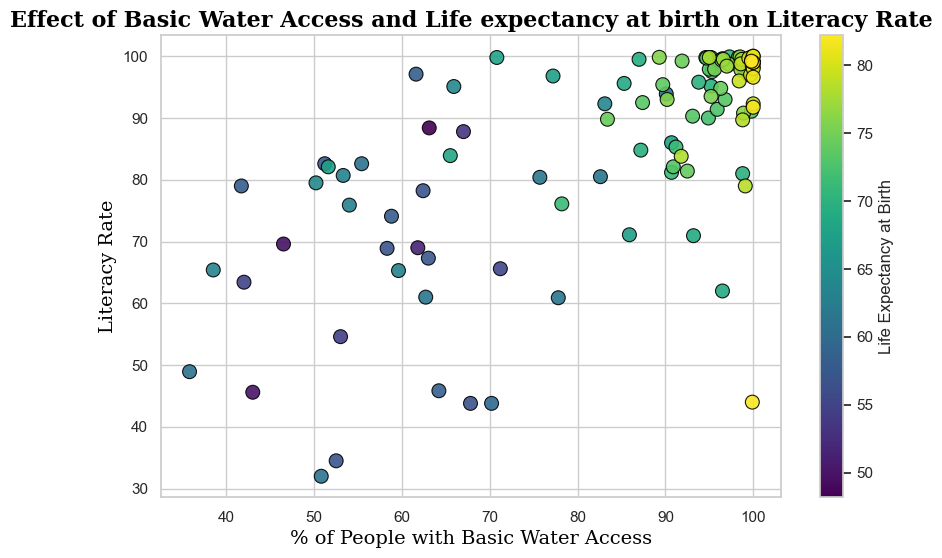

In [106]:
import matplotlib.colors as mcolors



merge_df_3 = other_data_raw.dropna(subset=['Life Expectancy at Birth', 'Literacy rate (2011)', 'Basic Water Access'])
merge_df_3 = merge_df_3.sort_values(by='Life Expectancy at Birth', ascending=True)
norm = mcolors.Normalize(vmin=merge_df_3['Life Expectancy at Birth'].min(), vmax=merge_df_3['Life Expectancy at Birth'].max())

# Create the scatter plot
sns.set_style("whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=merge_df_3,
                               x="Basic Water Access",
                               y="Literacy rate (2011)",
                               hue="Life Expectancy at Birth",
                               palette="viridis",
                               s = 100,
                               legend = False,
                               alpha=0.9,
                               edgecolor="black",
                               norm=norm)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # You need to set_array for the ScalarMappable
colorbar = plt.colorbar(sm)
colorbar.set_label('Life Expectancy at Birth')


# Enhance the plot
title_font = {'family': 'DejaVu Serif', 'color': 'black', 'weight': 'bold', 'size': 16}
axis_label_font = {'family': 'DejaVu Serif', 'color': 'black', 'size': 14}
plt.title("Effect of Basic Water Access and Life expectancy at birth on Literacy Rate", fontdict=title_font)
plt.xlabel("% of People with Basic Water Access", fontdict=axis_label_font)
plt.ylabel("Literacy Rate", fontdict=axis_label_font)
plt.show()